In [1]:
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
sys.path.append("FixedStrides")
from main import *
# results_au = pd.read_csv('ipResults_home_gtx980_australia.csv', sep=';')
results_au_32bit = pd.read_csv('ip_32bit_au.csv', sep=';')
results_tokyo = pd.read_csv('ip_32bit_tokyo.csv', sep=';')
results_au_32bit.drop(results_au_32bit.columns[len(results_au_32bit.columns)-1], axis=1, inplace=True)  # delete NaN column
results_tokyo.drop(results_tokyo.columns[len(results_tokyo.columns)-1], axis=1, inplace=True)  # delete NaN column

In [2]:
def plot_prefix_distribution(prefixes):
    lengths = []
    for p in prefixes:
        len_p = len(p)
        if len_p > len(lengths):
            lengths.extend([0] * (len_p - len(lengths)))
        lengths[len_p - 1] += 1
    plt.bar(range(1, len(lengths) + 1), lengths, align='center')
    plt.xlabel('Prefix length in bits')
    plt.ylabel('Num occurrences')
    plt.title('Prefix length distribution')
    plt.show()

In [3]:
prefixes_tokyo = utils.get_prefixes_from_file(file_name='FixedStrides/data/data-raw-table_tokyo_012016.txt')
prefixes_au = utils.get_prefixes_from_file(file_name='FixedStrides/data/data-raw-table_australia_012016.txt')

Read 576846 prefixes from file in 10.934512853622437 seconds
Read 565949 prefixes from file in 10.180753946304321 seconds


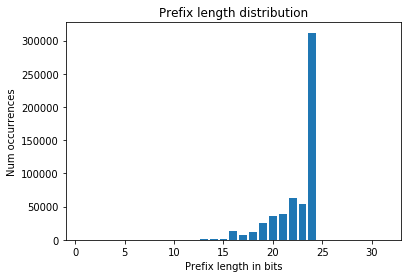

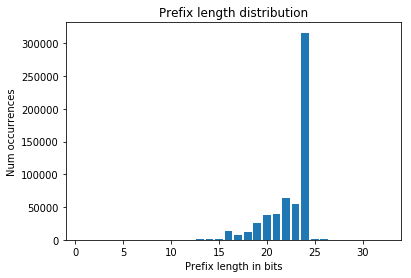

In [4]:
plot_prefix_distribution(prefixes_au)
plot_prefix_distribution(prefixes_tokyo)

In [5]:
strides_tokyo, nodes_tokyo = algos.fixed_strides_2(prefixes_tokyo)

In [6]:
strides_au, nodes_au = algos.fixed_strides_2(prefixes_au)

In [7]:
def append_stats(row: pd.Series, nodes: list):
    strides = row['Config'].replace('{', ' ').replace('}',' ').replace(',',' ').split()
    strides = [int(x) for x in strides]
    tmp, strides_nodes, cost, percent = utils.get_stats(nodes, strides, ignore_last_level=True)
    build_and_find = float(row['Build']) + float(row['Find'])
    build_and_match = float(row['Build']) + float(row['Match'])
    match_and_find = float(row['Match']) + float(row['Find'])
    return pd.Series([cost, percent, build_and_find, build_and_match, match_and_find])
    

In [8]:
newcol_names = ['Cost', 'Percent', 'BuildAndFind', 'BuildAndMatch', 'MatchAndFind']
newcols_au = results_au_32bit.apply(lambda row: append_stats(row, nodes_au), axis=1)
newcols_tokyo = results_tokyo.apply(lambda row: append_stats(row, nodes_tokyo), axis=1)
newcols_au.columns = newcol_names
newcols_tokyo.columns = newcol_names
results_au_32bit = results_au_32bit.join(newcols_au)
results_tokyo = results_tokyo.join(newcols_tokyo)

Attempting to find cost at level: 32 when len(nodes) is:  31
Attempting to find cost at level: 33 when len(nodes) is:  31
Attempting to find cost at level: 34 when len(nodes) is:  31
Attempting to find cost at level: 35 when len(nodes) is:  31
Attempting to find cost at level: 36 when len(nodes) is:  31
Attempting to find cost at level: 37 when len(nodes) is:  31
Attempting to find cost at level: 38 when len(nodes) is:  31
Attempting to find cost at level: 39 when len(nodes) is:  31
Attempting to find cost at level: 32 when len(nodes) is:  32
Attempting to find cost at level: 33 when len(nodes) is:  32
Attempting to find cost at level: 34 when len(nodes) is:  32
Attempting to find cost at level: 35 when len(nodes) is:  32
Attempting to find cost at level: 36 when len(nodes) is:  32
Attempting to find cost at level: 37 when len(nodes) is:  32
Attempting to find cost at level: 38 when len(nodes) is:  32
Attempting to find cost at level: 39 when len(nodes) is:  32


In [9]:
results_au_32bit = results_au_32bit.sort_values('MatchAndFind')
results_au_32bit[['Config', 'Match', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'RandomMatch', 'RandomSort', 'RandomSortedMatch']]

,Config,Match,Find,MatchAndFind,Build,TreeMemoryUniqueOnly,Cost,RandomMatch,RandomSort,RandomSortedMatch
23,"{3, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.674880,7.820736,9.495616,84.878944,3360524,1596820.0,0.630176,23.113024,0.535392
24,"{1, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",2.086752,7.741792,9.828544,64.191811,3364564,1595754.0,1.078528,24.907104,0.795840
25,"{1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.975168,8.420448,10.395616,96.345444,3361708,1596924.0,0.779264,27.289761,0.593216
33,"{16, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",1.299040,20.669855,21.968895,53.926208,3604428,1589780.0,34.374687,16.878304,34.415840
32,"{3, 5, 4, 4, 2, 2, 2, 2, 8, 1, 1, 1, 1, 1, 1, ...",8.755872,15.190176,23.946048,41.038368,2274564,1375572.0,8.708704,15.799712,8.411968
9,"{14, 2, 2, 2, 2, 2, 8}",1.024960,24.973633,25.998593,26.590464,2874868,1356220.0,4.872288,6.845664,4.555232
14,"{7, 7, 2, 2, 2, 2, 2, 8}",1.323072,24.823999,26.147071,31.921696,2830684,1354172.0,4.089216,7.941824,1.394912
20,"{8, 8, 2, 2, 2, 2, 8}",0.973760,25.542433,26.516193,25.324608,2846812,1356796.0,8.242112,6.347328,8.204960
26,"{2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2}",1.507200,25.736193,27.243393,48.455265,2825220,1355912.0,0.605536,14.050240,0.416160
31,"{3, 5, 4, 4, 2, 2, 2, 2, 8}",1.130656,26.432159,27.562815,31.261057,2817516,1350228.0,0.711104,8.476896,0.631936


In [10]:
results_tokyo = results_tokyo.sort_values('TreeMemoryUniqueOnly')
results_tokyo[['Config', 'Match', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'RandomMatch', 'RandomSort', 'RandomSortedMatch']]

,Config,Match,Find,MatchAndFind,Build,TreeMemoryUniqueOnly,Cost,RandomMatch,RandomSort,RandomSortedMatch
32,"{3, 5, 4, 4, 2, 2, 2, 2, 8, 1, 1, 1, 1, 1, 1, ...",8.598528,16.199392,24.797920,52.238560,2324088,1636316.0,8.760288,17.835775,8.217824
16,"{8, 8, 16}",10.853280,60.302078,71.155358,17.523487,2358400,53504.0,9.318240,4.598496,9.322816
2,"{16, 16}",10.662016,60.563042,71.225058,18.032543,2577168,65536.0,33.625088,5.306048,32.249249
13,"{6, 6, 4, 4, 4, 8}",1.789856,35.926079,37.715935,24.767839,2774408,1984064.0,1.277888,6.318272,0.596640
12,"{12, 4, 4, 4, 8}",1.566656,35.573505,37.140161,22.521248,2782048,1984512.0,1.590400,6.785088,1.309056
18,"{8, 8, 4, 4, 8}",1.646944,35.453663,37.100607,25.598656,2797048,1990208.0,8.365792,4.874176,8.513120
11,"{14, 5, 5, 8}",2.265984,36.340672,38.606656,20.217440,2849040,2715680.0,4.968736,4.789056,4.723360
22,"{4, 4, 4, 4, 4, 4, 4, 4}",1.831744,36.650368,38.482112,31.648865,2869952,1999856.0,1.855104,7.892672,0.684800
15,"{7, 7, 4, 4, 2, 8}",1.023488,33.156128,34.179616,26.415104,2926160,1653940.0,3.851008,6.089696,1.566016
31,"{3, 5, 4, 4, 2, 2, 2, 2, 8}",1.132224,27.125759,28.257983,36.586910,2944592,1382364.0,0.724960,10.723552,0.672064


In [11]:
results_au_32bit = results_au_32bit.sort_values('TreeMemoryUniqueOnly')
results_au_32bit[['Config', 'TreeMemoryUniqueOnly', 'Cost', 'Percent', 'TreeLevels', 'ChildrenMemory', 'ChildrenCountsMemory', 'ScanMemory', 'PreScanMemory', 'PermuationMemory', 'LengthsMemory', 'MasksPartsMemory', 'ContainerSumMemory', 'ContainerItemsMemory', 'ContainerStartsMemory', 'ContainerLengthsMemory']]

,Config,TreeMemoryUniqueOnly,Cost,Percent,TreeLevels,ChildrenMemory,ChildrenCountsMemory,ScanMemory,PreScanMemory,PermuationMemory,LengthsMemory,MasksPartsMemory,ContainerSumMemory,ContainerItemsMemory,ContainerStartsMemory,ContainerLengthsMemory
32,"{3, 5, 4, 4, 2, 2, 2, 2, 8, 1, 1, 1, 1, 1, 1, ...",2274564,1375572.0,86.139283,"{1,1,1,1,40,56,99,158,194,}",6000,36,72,72,2263796,2263796,2263796,2268384,2263796,2312,2276
16,"{8, 8, 16}",2309620,53760.0,3.366489,"{1,40,425,}",42000,12,12,12,2263796,2263796,2263796,2267584,2263796,1900,1888
2,"{16, 16}",2529420,65536.0,4.103910,"{1,425,}",262152,8,8,8,2263796,2263796,2263796,2267244,2263796,1728,1720
13,"{6, 6, 4, 4, 4, 8}",2623452,1934224.0,121.122464,"{1,40,124,425,4268,222,}",318824,24,24,24,2263796,2263796,2263796,2304556,2263796,20392,20368
12,"{12, 4, 4, 4, 8}",2628980,1934672.0,121.150518,"{1,124,425,4268,222,}",324704,20,20,20,2263796,2263796,2263796,2304216,2263796,20220,20200
22,"{4, 4, 4, 4, 4, 4, 4, 4}",2631476,1935744.0,121.217647,"{1,16,40,124,425,4268,222,57,}",326200,32,32,32,2263796,2263796,2263796,2305180,2263796,20708,20676
18,"{8, 8, 4, 4, 8}",2645972,1940720.0,121.529248,"{1,40,425,4268,222,}",342368,20,20,20,2263796,2263796,2263796,2303544,2263796,19884,19864
11,"{14, 5, 5, 8}",2660524,2647968.0,165.817613,"{1,201,2220,222,}",375448,16,16,16,2263796,2263796,2263796,2285028,2263796,10624,10608
21,"{4, 4, 4, 4, 8, 8}",2717436,5429088.0,339.973299,"{1,16,40,124,425,222,}",446824,24,24,24,2263796,2263796,2263796,2270540,2263796,3384,3360
17,"{8, 8, 8, 8}",2746636,5435648.0,340.384090,"{1,40,425,222,}",477208,16,16,16,2263796,2263796,2263796,2269380,2263796,2800,2784


In [12]:
results_tokyo = results_tokyo.sort_values('Match')
results_tokyo[['Config', 'Match', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'Percent', 'ChildrenMemory', 'ContainerStartsMemory', 'ContainerLengthsMemory']]

,Config,Match,Find,MatchAndFind,Build,TreeMemoryUniqueOnly,Cost,Percent,ChildrenMemory,ContainerStartsMemory,ContainerLengthsMemory
29,"{1, 16, 2, 2, 2, 1, 8}",0.885728,34.459042,35.344770,31.356735,3709104,1506516.0,92.105147,1010704,195480,195452
19,"{8, 8, 4, 2, 2, 8}",1.008064,34.906273,35.914337,27.645311,2970800,1432428.0,87.575566,463080,100144,100120
8,"{16, 2, 2, 2, 2, 8}",1.017824,26.413408,27.431232,30.590528,3190592,1400628.0,85.631383,667752,107704,107680
15,"{7, 7, 4, 4, 2, 8}",1.023488,33.156128,34.179616,26.415104,2926160,1653940.0,101.118334,447944,85392,85368
5,"{16, 4, 2, 2, 8}",1.053184,34.755840,35.809024,27.404768,3189568,1444460.0,88.311177,682208,99968,99948
9,"{14, 2, 2, 2, 2, 2, 8}",1.087520,25.738111,26.825631,35.543423,3003792,1388436.0,84.885990,477664,109344,109316
14,"{7, 7, 2, 2, 2, 2, 2, 8}",1.100480,25.531937,26.632417,31.351328,2958568,1386388.0,84.760780,432104,109508,109476
31,"{3, 5, 4, 4, 2, 2, 2, 2, 8}",1.132224,27.125759,28.257983,36.586910,2944592,1382364.0,84.514761,419936,108600,108564
28,"{1, 16, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1}",1.254976,34.337090,35.592066,60.277760,3748952,1511812.0,92.428933,1040776,200344,200292
10,"{14, 4, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1}",1.277600,33.578911,34.856511,42.287552,3010208,1660496.0,101.519153,518984,91872,91824


In [13]:
results_au_32bit = results_tokyo.sort_values('Find')
results_au_32bit[['Config', 'Match', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'Percent', 'ChildrenMemory', 'ContainerStartsMemory', 'ContainerLengthsMemory']]

,Config,Match,Find,MatchAndFind,Build,TreeMemoryUniqueOnly,Cost,Percent,ChildrenMemory,ContainerStartsMemory,ContainerLengthsMemory
24,"{1, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",1.562144,8.010656,9.572800,82.421471,3554832,1634482.0,99.928713,627448,309908,309816
25,"{1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",3.397856,8.654368,12.052224,101.517410,3551560,1635648.0,100.000000,621616,311152,311024
23,"{3, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",3.182464,8.874400,12.056864,89.552513,3550600,1635544.0,99.993642,621432,310784,310676
32,"{3, 5, 4, 4, 2, 2, 2, 2, 8, 1, 1, 1, 1, 1, 1, ...",8.598528,16.199392,24.797920,52.238560,2324088,1636316.0,100.040840,7632,4464,4428
33,"{16, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",1.335136,21.609953,22.945089,73.254814,3783384,1628146.0,99.541344,868776,303544,303476
14,"{7, 7, 2, 2, 2, 2, 2, 8}",1.100480,25.531937,26.632417,31.351328,2958568,1386388.0,84.760780,432104,109508,109476
9,"{14, 2, 2, 2, 2, 2, 8}",1.087520,25.738111,26.825631,35.543423,3003792,1388436.0,84.885990,477664,109344,109316
8,"{16, 2, 2, 2, 2, 8}",1.017824,26.413408,27.431232,30.590528,3190592,1400628.0,85.631383,667752,107704,107680
26,"{2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2}",1.553920,26.675392,28.229312,53.735680,2983304,1392816.0,85.153774,450200,112796,112732
20,"{8, 8, 2, 2, 2, 2, 8}",1.280544,26.833984,28.114528,30.563360,2971824,1388596.0,84.895772,448624,107880,107852


In [14]:
results_au_32bit['TreeMemoryUniqueOnly'].corr(results_au_32bit['Match'])

0.8388978146436453

In [15]:
results_au_32bit['TreeMemoryUniqueOnly'].corr(results_au_32bit['Find'])

0.9575933015424557

In [16]:
results_au_32bit['TreeMemoryUniqueOnly'].corr(results_au_32bit['Build'])

0.08705514592843909

In [17]:
results_tokyo['ChildrenMemory'].corr(results_au_32bit['Cost'])

0.9100197701843386

In [18]:
results_au_32bit['ChildrenMemory'].corr(results_au_32bit['Cost'])

0.9100197701843386

In [19]:
results_au_32bit['Match'].corr(results_au_32bit['Cost'])

0.7820032283997276

In [20]:
results_tokyo['Match'].corr(results_au_32bit['Cost'])

0.7820032283997276

In [21]:
results_tokyo.columns

Index(['deviceId', 'deviceName', 'Dictionary', 'Load', 'Count', 'Sort',
       'Config', 'Reshape', 'Build', 'TreeMemory', 'TreeLevels', 'Depth',
       'TreeMemoryUniqueOnly', 'ChildrenMemory', 'ChildrenCountsMemory',
       'ScanMemory', 'PreScanMemory', 'PermuationMemory', 'LengthsMemory',
       'MasksPartsMemory', 'ContainerSumMemory', 'ContainerItemsMemory',
       'ContainerStartsMemory', 'ContainerLengthsMemory', 'Find', 'Match',
       'RandomCount', 'RandomMatch', 'RandomSort', 'RandomSortedMatch',
       'HitRate', 'Cost', 'Percent', 'BuildAndFind', 'BuildAndMatch',
       'MatchAndFind'],
      dtype='object')

In [22]:
# results_tokyo[['Config', 'Build', 'Cost', 'Percent', 'TreeMemory','BuildAndFind', 'Match', 'Find', 'RandomMatch', 'RandomSortedMatch']]

In [23]:
# results_au_32bit[['Config', 'Build', 'TreeMemory', 'Match', 'Find','BuildAndFind','RandomCount', 'RandomMatch', 'RandomSort', 'RandomSortedMatch', 'HitRate', 'Cost', 'Percent']]